In [119]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### Creating Dataframes by Loading CSV Files

In [120]:
df_0_shot = pd.read_csv('../results/mbpp/mbpp_0_shot.csv')
df_3_shot = pd.read_csv('../results/mbpp/mbpp_3_shot.csv')

In [121]:
df_0_shot.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18896 entries, 0 to 18895
Data columns (total 25 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   LLM                          18896 non-null  object 
 1   Benchmark prompt             18896 non-null  object 
 2   Execution time (s)           18896 non-null  float64
 3   CPU Energy (J)               18896 non-null  float64
 4   RAM Energy (J)               18896 non-null  float64
 5   GPU Energy (J)               18896 non-null  float64
 6   CPU Power (W)                18896 non-null  float64
 7   RAM Power (W)                18896 non-null  float64
 8   GPU Power (W)                18896 non-null  float64
 9   CO2 emissions (Kg)           18896 non-null  float64
 10  CO2 emissions rate (Kg/s)    18896 non-null  float64
 11  MBPP (unsanitized) pass@1    18896 non-null  float64
 12  MBPP+ (unsanitized) pass@1   18896 non-null  float64
 13  MBPP (sanitized)

In [122]:
df_3_shot.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26250 entries, 0 to 26249
Data columns (total 25 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   LLM                          26250 non-null  object 
 1   Benchmark prompt             26250 non-null  object 
 2   Execution time (s)           26250 non-null  float64
 3   CPU Energy (J)               26250 non-null  float64
 4   RAM Energy (J)               26250 non-null  float64
 5   GPU Energy (J)               26250 non-null  float64
 6   CPU Power (W)                26250 non-null  float64
 7   RAM Power (W)                26250 non-null  float64
 8   GPU Power (W)                26250 non-null  float64
 9   CO2 emissions (Kg)           26250 non-null  float64
 10  CO2 emissions rate (Kg/s)    26250 non-null  float64
 11  MBPP (unsanitized) pass@1    26250 non-null  float64
 12  MBPP+ (unsanitized) pass@1   26250 non-null  float64
 13  MBPP (sanitized)

### Cast data types

In [123]:
# Converting 'LLM' and 'Benchmark prompt' to string
df_0_shot['LLM'] = df_0_shot['LLM'].astype(str)
df_0_shot['Benchmark prompt'] = df_0_shot['Benchmark prompt'].astype(str)

df_3_shot['LLM'] = df_0_shot['LLM'].astype(str)
df_3_shot['Benchmark prompt'] = df_0_shot['Benchmark prompt'].astype(str)

### Remove outliers

In [124]:

import pandas as pd

THRESHOLD = 0.5
# Função para remover outliers usando o método do IQR
def remove_outliers(group, threshold=THRESHOLD):
    # Calcular IQR
    Q1 = group['CPU Energy (J)'].quantile(0.25)
    Q3 = group['CPU Energy (J)'].quantile(0.75)
    IQR = Q3 - Q1
    
    # Calcular limites para outliers
    lower_bound = Q1 - threshold * IQR
    upper_bound = Q3 + threshold * IQR
    
    # Filtrar os dados para remover outliers
    filtered_group = group[(group['CPU Energy (J)'] >= lower_bound) & (group['CPU Energy (J)'] <= upper_bound)]
    
    # Calcular o número de outliers removidos
    num_removed = len(group) - len(filtered_group)
    
    return filtered_group, num_removed

# Inicializando listas para armazenar o número de outliers removidos
outliers_list_0 = []
outliers_list_3 = []

# Remover outliers para df_0_shot
df_0_no_outliers_list = []
for (llm, prompt), group in df_0_shot.groupby(['LLM', 'Benchmark prompt']):
    filtered_group, num_removed = remove_outliers(group, threshold=THRESHOLD)  # Ajuste do fator
    df_0_no_outliers_list.append(filtered_group)
    outliers_list_0.append([llm, prompt, num_removed])  # Armazenar contagem de outliers removidos

df_0_no_outliers = pd.concat(df_0_no_outliers_list).reset_index(drop=True)

# Remover outliers para df_3_shot
df_3_no_outliers_list = []
for (llm, prompt), group in df_3_shot.groupby(['LLM', 'Benchmark prompt']):
    filtered_group, num_removed = remove_outliers(group, threshold=THRESHOLD)  # Ajuste do fator
    df_3_no_outliers_list.append(filtered_group)
    outliers_list_3.append([llm, prompt, num_removed])  # Armazenar contagem de outliers removidos

df_3_no_outliers = pd.concat(df_3_no_outliers_list).reset_index(drop=True)



### Statistical tests

In [125]:
df_0_no_outliers['Origin'] = '0-shot'
df_3_no_outliers['Origin'] = '3-shot'

df_combined_no_outliers = pd.concat([df_0_no_outliers, df_3_no_outliers], ignore_index=True)
df_combined_no_outliers.columns


Index(['LLM', 'Benchmark prompt', 'Execution time (s)', 'CPU Energy (J)',
       'RAM Energy (J)', 'GPU Energy (J)', 'CPU Power (W)', 'RAM Power (W)',
       'GPU Power (W)', 'CO2 emissions (Kg)', 'CO2 emissions rate (Kg/s)',
       'MBPP (unsanitized) pass@1', 'MBPP+ (unsanitized) pass@1',
       'MBPP (sanitized) pass@1', 'MBPP+ (sanitized) pass@1',
       'MBPP (unsanitized) pass@10', 'MBPP+ (unsanitized) pass@10',
       'MBPP (sanitized) pass@10', 'MBPP+ (sanitized) pass@10',
       'GoogleBLEU (unsanitized)', 'CodeBLEU (unsanitized)',
       'SacreBLEU (unsanitized)', 'GoogleBLEU (sanitized)',
       'CodeBLEU (sanitized)', 'SacreBLEU (sanitized)', 'Origin'],
      dtype='object')

#### By LLM

In [126]:
import pandas as pd
from scipy.stats import shapiro

# Inicializar listas para armazenar os resultados
results = []

# Iterar sobre os grupos de df_combined_no_outliers
for (llm, prompt_type), group in df_combined_no_outliers.groupby(['LLM', 'Origin']):
    # Teste de Shapiro-Wilk para CPU Energy
    stat_cpu_energy, p_value_cpu_energy = shapiro(group['CPU Energy (J)'])  
    is_normal_cpu_energy = 'Normal' if p_value_cpu_energy > 0.05 else 'Not Normal'
    results.append([llm, 'CPU Energy (J)', stat_cpu_energy, p_value_cpu_energy, is_normal_cpu_energy, prompt_type])
    
    # Teste de Shapiro-Wilk para Execution Time
    stat_execution_time, p_value_execution_time = shapiro(group['Execution time (s)'])  
    is_normal_execution_time = 'Normal' if p_value_execution_time > 0.05 else 'Not Normal'
    results.append([llm, 'Execution Time (s)', stat_execution_time, p_value_execution_time, is_normal_execution_time, prompt_type])

# Criar um DataFrame com os resultados
shapiro_results = pd.DataFrame(results, columns=[
    'LLM', 'Metric', 'Statistic', 'p-value', 'Normality', 'Prompt Type'])

# Exibir os resultados
shapiro_results

,LLM,Metric,Statistic,p-value,Normality,Prompt Type
0,Meta-Llama-3-8B-Instruct-Q6_K,CPU Energy (J),0.902154,7.415671e-42,Not Normal,0-shot
1,Meta-Llama-3-8B-Instruct-Q6_K,Execution Time (s),0.900313,3.845163e-42,Not Normal,0-shot
2,Meta-Llama-3-8B-Instruct-Q6_K,CPU Energy (J),0.740074,0.000000e+00,Not Normal,3-shot
3,Meta-Llama-3-8B-Instruct-Q6_K,Execution Time (s),0.738220,0.000000e+00,Not Normal,3-shot
4,codegeex4-all-9b-Q6_K_L,CPU Energy (J),0.738540,0.000000e+00,Not Normal,0-shot
5,codegeex4-all-9b-Q6_K_L,Execution Time (s),0.738035,0.000000e+00,Not Normal,0-shot
6,codegeex4-all-9b-Q6_K_L,CPU Energy (J),0.771483,0.000000e+00,Not Normal,3-shot
7,codegeex4-all-9b-Q6_K_L,Execution Time (s),0.769932,0.000000e+00,Not Normal,3-shot
8,codellama-7b-instruct.Q5_K_M,CPU Energy (J),0.538971,0.000000e+00,Not Normal,0-shot
9,codellama-7b-instruct.Q5_K_M,Execution Time (s),0.536049,0.000000e+00,Not Normal,0-shot


In [127]:
#pretty_print_df = shapiro_results[shapiro_results["Metric"] == "CPU Energy (J)"]
pretty_print_df = shapiro_results[shapiro_results["Metric"] == "Execution Time (s)"]

pretty_print_df = pretty_print_df.drop("Metric", axis=1)
pretty_print_df


,LLM,Statistic,p-value,Normality,Prompt Type
1,Meta-Llama-3-8B-Instruct-Q6_K,0.900313,3.845163e-42,Not Normal,0-shot
3,Meta-Llama-3-8B-Instruct-Q6_K,0.738220,0.000000e+00,Not Normal,3-shot
5,codegeex4-all-9b-Q6_K_L,0.738035,0.000000e+00,Not Normal,0-shot
7,codegeex4-all-9b-Q6_K_L,0.769932,0.000000e+00,Not Normal,3-shot
9,codellama-7b-instruct.Q5_K_M,0.536049,0.000000e+00,Not Normal,0-shot
11,codellama-7b-instruct.Q5_K_M,0.502455,0.000000e+00,Not Normal,3-shot
13,deepseek-coder-6.7b-instruct.Q5_K_M,0.840389,0.000000e+00,Not Normal,0-shot
15,deepseek-coder-6.7b-instruct.Q5_K_M,0.769359,0.000000e+00,Not Normal,3-shot
17,starling-lm-7b-alpha.Q5_K_S,0.312959,0.000000e+00,Not Normal,0-shot
19,starling-lm-7b-alpha.Q5_K_S,0.734167,0.000000e+00,Not Normal,3-shot


In [128]:
shapiro_results.groupby(['LLM', "Metric",'Prompt Type', 'Normality']).size().unstack(fill_value=0)

Normality                                                           Not Normal
LLM                                 Metric             Prompt Type            
Meta-Llama-3-8B-Instruct-Q6_K       CPU Energy (J)     0-shot                1
                                                       3-shot                1
                                    Execution Time (s) 0-shot                1
                                                       3-shot                1
codegeex4-all-9b-Q6_K_L             CPU Energy (J)     0-shot                1
                                                       3-shot                1
                                    Execution Time (s) 0-shot                1
                                                       3-shot                1
codellama-7b-instruct.Q5_K_M        CPU Energy (J)     0-shot                1
                                                       3-shot                1
                                    Execution Time (s) 0-shot                1
                                                       3-shot                1
deepseek-coder-6.7b-instruct.Q5_K_M CPU Energy (J)     0-shot                1
                                                       3-shot                1
                                    Execution Time (s) 0-shot                1
                                                       3-shot                1
starling-lm-7b-alpha.Q5_K_S         CPU Energy (J)     0-shot                1
                                                       3-shot                1
                                    Execution Time (s) 0-shot                1
                                                       3-shot                1

In [129]:
import pandas as pd
from scipy.stats import mannwhitneyu

# Inicializar listas para armazenar os resultados do teste de Mann-Whitney
mannwhitney_results = []

# Definir o nível de significância
alpha = 0.05

# Iterar sobre os grupos de df_combined_no_outliers (sem 'Benchmark prompt')
for llm, group in df_combined_no_outliers.groupby('LLM'):
    # Extrair os dados de 0-shot e 3-shot para CPU Energy
    group_0_shot_cpu = group[group['Origin'] == '0-shot']['CPU Energy (J)']
    group_3_shot_cpu = group[group['Origin'] == '3-shot']['CPU Energy (J)']
    
    # Extrair os dados de 0-shot e 3-shot para Execution Time
    group_0_shot_exec = group[group['Origin'] == '0-shot']['Execution time (s)']
    group_3_shot_exec = group[group['Origin'] == '3-shot']['Execution time (s)']
    
    # Adicionar resultados para CPU Energy (0-shot e 3-shot)
    if len(group_0_shot_cpu) > 0 and len(group_3_shot_cpu) > 0:
        stat_cpu, p_value_cpu = mannwhitneyu(group_0_shot_cpu, group_3_shot_cpu, alternative='two-sided')
        significance_cpu = 'Significant' if p_value_cpu < alpha else 'Not Significant'
        mannwhitney_results.append([llm, 'CPU Energy', stat_cpu, p_value_cpu, '0-shot', significance_cpu])
        mannwhitney_results.append([llm, 'CPU Energy', stat_cpu, p_value_cpu, '3-shot', significance_cpu])
    
    # Adicionar resultados para Execution Time (0-shot e 3-shot)
    if len(group_0_shot_exec) > 0 and len(group_3_shot_exec) > 0:
        stat_exec, p_value_exec = mannwhitneyu(group_0_shot_exec, group_3_shot_exec, alternative='two-sided')
        significance_exec = 'Significant' if p_value_exec < alpha else 'Not Significant'
        mannwhitney_results.append([llm, 'Execution Time', stat_exec, p_value_exec, '0-shot', significance_exec])
        mannwhitney_results.append([llm, 'Execution Time', stat_exec, p_value_exec, '3-shot', significance_exec])

# Criar um DataFrame com os resultados do teste de Mann-Whitney
mannwhitney_results_df = pd.DataFrame(mannwhitney_results, columns=['LLM', 'Metric', 'Statistic', 'p-value', 'Origin', 'Significance'])

# Exibir os resultados
mannwhitney_results_df



,LLM,Metric,Statistic,p-value,Origin,Significance
0,Meta-Llama-3-8B-Instruct-Q6_K,CPU Energy,9811501.0,0.000000e+00,0-shot,Significant
1,Meta-Llama-3-8B-Instruct-Q6_K,CPU Energy,9811501.0,0.000000e+00,3-shot,Significant
2,Meta-Llama-3-8B-Instruct-Q6_K,Execution Time,9807581.0,0.000000e+00,0-shot,Significant
3,Meta-Llama-3-8B-Instruct-Q6_K,Execution Time,9807581.0,0.000000e+00,3-shot,Significant
4,codegeex4-all-9b-Q6_K_L,CPU Energy,6403806.0,1.198613e-128,0-shot,Significant
5,codegeex4-all-9b-Q6_K_L,CPU Energy,6403806.0,1.198613e-128,3-shot,Significant
6,codegeex4-all-9b-Q6_K_L,Execution Time,6482905.0,7.337724e-141,0-shot,Significant
7,codegeex4-all-9b-Q6_K_L,Execution Time,6482905.0,7.337724e-141,3-shot,Significant
8,codellama-7b-instruct.Q5_K_M,CPU Energy,3362718.0,1.128866e-97,0-shot,Significant
9,codellama-7b-instruct.Q5_K_M,CPU Energy,3362718.0,1.128866e-97,3-shot,Significant


In [130]:
#pretty_print_df = mannwhitney_results_df[mannwhitney_results_df["Metric"] == "CPU Energy"]
pretty_print_df = mannwhitney_results_df[mannwhitney_results_df["Metric"] == "Execution Time"]

pretty_print_df = pretty_print_df.drop("Metric", axis=1)
pretty_print_df


,LLM,Statistic,p-value,Origin,Significance
2,Meta-Llama-3-8B-Instruct-Q6_K,9807581.0,0.000000e+00,0-shot,Significant
3,Meta-Llama-3-8B-Instruct-Q6_K,9807581.0,0.000000e+00,3-shot,Significant
6,codegeex4-all-9b-Q6_K_L,6482905.0,7.337724e-141,0-shot,Significant
7,codegeex4-all-9b-Q6_K_L,6482905.0,7.337724e-141,3-shot,Significant
10,codellama-7b-instruct.Q5_K_M,3780693.0,1.980169e-51,0-shot,Significant
11,codellama-7b-instruct.Q5_K_M,3780693.0,1.980169e-51,3-shot,Significant
14,deepseek-coder-6.7b-instruct.Q5_K_M,8684850.0,0.000000e+00,0-shot,Significant
15,deepseek-coder-6.7b-instruct.Q5_K_M,8684850.0,0.000000e+00,3-shot,Significant
18,starling-lm-7b-alpha.Q5_K_S,8494901.0,0.000000e+00,0-shot,Significant
19,starling-lm-7b-alpha.Q5_K_S,8494901.0,0.000000e+00,3-shot,Significant


### Create dataframes with all the average values

In [131]:
# List of columns to calculate the mean for
columns_to_average = ['Execution time (s)', 'CPU Energy (J)',
       'MBPP (unsanitized) pass@1', 'MBPP+ (unsanitized) pass@1',
       'MBPP (sanitized) pass@1', 'MBPP+ (sanitized) pass@1',
       'MBPP (unsanitized) pass@10', 'MBPP+ (unsanitized) pass@10',
       'MBPP (sanitized) pass@10', 'MBPP+ (sanitized) pass@10',
       'GoogleBLEU (unsanitized)', 'CodeBLEU (unsanitized)',
       'SacreBLEU (unsanitized)', 'GoogleBLEU (sanitized)',
       'CodeBLEU (sanitized)', 'SacreBLEU (sanitized)']

# Grouping by LLM and Programming Language, and calculating the mean for the specified columns
df_0_averages = df_0_no_outliers.groupby(['LLM'])[columns_to_average].mean().reset_index()
df_3_averages = df_3_no_outliers.groupby(['LLM'])[columns_to_average].mean().reset_index()

df_0_averages["SacreBLEU (unsanitized)"] = df_0_averages["SacreBLEU (unsanitized)"] / 100
df_0_averages["SacreBLEU (sanitized)"] = df_0_averages["SacreBLEU (sanitized)"] / 100

df_3_averages["SacreBLEU (unsanitized)"] = df_3_averages["SacreBLEU (unsanitized)"] / 100
df_3_averages["SacreBLEU (sanitized)"] = df_3_averages["SacreBLEU (sanitized)"] / 100

# Adicionando uma coluna para cada DataFrame
df_0_averages['Shot'] = '0-shot'
df_3_averages['Shot'] = '3-shot'

# Concatenando os DataFrames
df_combined_mbpp = pd.concat([df_0_averages, df_3_averages], ignore_index=True)
df_combined_mbpp

,LLM,Execution time (s),CPU Energy (J),MBPP (unsanitized) pass@1,MBPP+ (unsanitized) pass@1,MBPP (sanitized) pass@1,MBPP+ (sanitized) pass@1,MBPP (unsanitized) pass@10,MBPP+ (unsanitized) pass@10,MBPP (sanitized) pass@10,MBPP+ (sanitized) pass@10,GoogleBLEU (unsanitized),CodeBLEU (unsanitized),SacreBLEU (unsanitized),GoogleBLEU (sanitized),CodeBLEU (sanitized),SacreBLEU (sanitized),Shot
0,Meta-Llama-3-8B-Instruct-Q6_K,65.649756,4336.466439,0.654000,0.542000,0.686000,0.569000,0.835000,0.725000,0.837000,0.728000,0.069140,0.315794,0.062450,0.168783,0.244199,0.185539,0-shot
1,codegeex4-all-9b-Q6_K_L,17.069976,1127.984104,0.000000,0.000000,0.274000,0.212000,0.000000,0.000000,0.595000,0.489000,0.192322,0.309949,0.179499,0.176930,0.189083,0.176504,0-shot
2,codellama-7b-instruct.Q5_K_M,8.847133,597.782381,0.193000,0.167000,0.610000,0.517000,0.685000,0.595000,0.873000,0.767000,0.101692,0.327037,0.091833,0.255243,0.260233,0.273627,0-shot
3,deepseek-coder-6.7b-instruct.Q5_K_M,35.003395,2296.474371,0.193000,0.167000,0.610000,0.517000,0.685000,0.595000,0.873000,0.767000,0.101692,0.327037,0.091833,0.255243,0.260233,0.273627,0-shot
4,starling-lm-7b-alpha.Q5_K_S,79.387905,5201.048618,0.074000,0.060000,0.428000,0.354000,0.444000,0.370000,0.820000,0.698000,0.043459,0.325714,0.037512,0.191784,0.232059,0.223515,0-shot
5,Meta-Llama-3-8B-Instruct-Q6_K,8.404732,597.672158,0.189239,0.163618,0.604247,0.511848,0.677383,0.587888,0.871325,0.764819,0.187449,0.325431,0.182965,0.318473,0.308447,0.336522,3-shot
6,codegeex4-all-9b-Q6_K_L,10.235238,697.542414,0.003005,0.002600,0.279231,0.216749,0.010665,0.009264,0.599328,0.493328,0.249802,0.301452,0.247107,0.261156,0.263478,0.286512,3-shot
7,codellama-7b-instruct.Q5_K_M,9.508065,677.677904,0.096343,0.078567,0.437939,0.362282,0.459062,0.383675,0.820655,0.699156,0.072520,0.293982,0.064890,0.226153,0.252981,0.248980,3-shot
8,deepseek-coder-6.7b-instruct.Q5_K_M,10.275680,692.523864,0.000000,0.000000,0.274000,0.212000,0.000000,0.000000,0.595000,0.489000,0.232791,0.303344,0.226073,0.239567,0.244764,0.259863,3-shot
9,starling-lm-7b-alpha.Q5_K_S,8.364644,581.524990,0.193000,0.167000,0.610000,0.517000,0.685000,0.595000,0.873000,0.767000,0.156937,0.324664,0.149289,0.304495,0.297625,0.322965,3-shot


### Plots

#### [PAPER] Energy vs Time

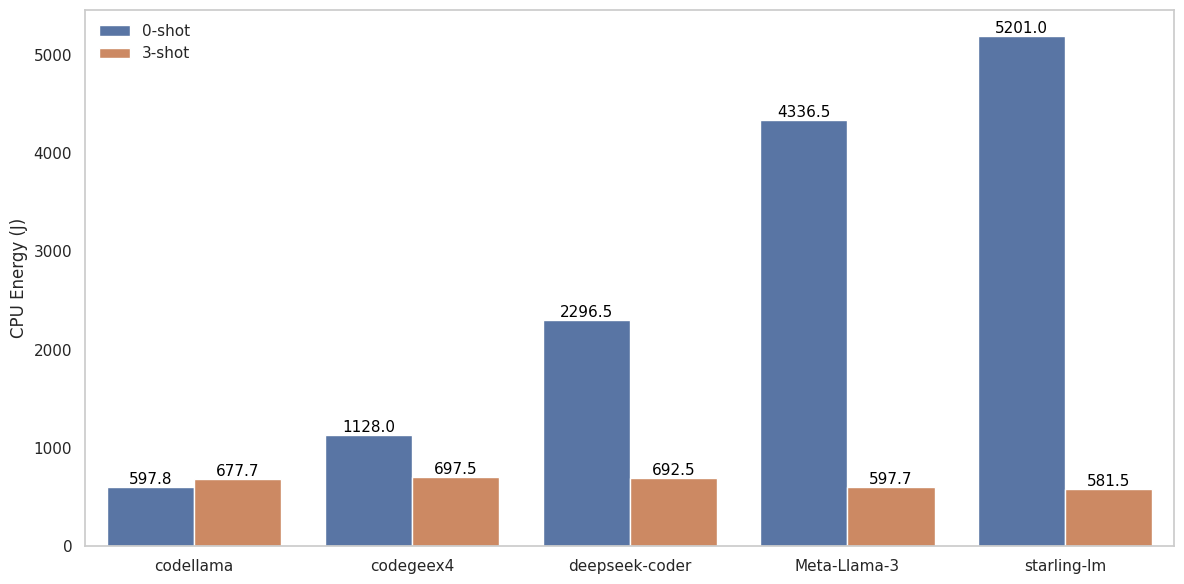

In [132]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Mapeamento para nomes mais curtos dos modelos
mapping = {
    "codellama-7b-instruct.Q5_K_M": "codellama",
    "codegeex4-all-9b-Q6_K_L": "codegeex4",
    "deepseek-coder-6.7b-instruct.Q5_K_M": "deepseek-coder",
    "Meta-Llama-3-8B-Instruct-Q6_K": "Meta-Llama-3",
    "starling-lm-7b-alpha.Q5_K_S": "starling-lm"
}

# Filtrando os dados para 0-shot e 3-shot
df_0_shot = df_combined_mbpp[df_combined_mbpp['Shot'] == '0-shot'][['LLM', 'CPU Energy (J)', 'Execution time (s)']]
df_3_shot = df_combined_mbpp[df_combined_mbpp['Shot'] == '3-shot'][['LLM', 'CPU Energy (J)', 'Execution time (s)']]

# Aplicando o mapeamento para nomes mais curtos
df_0_shot['LLM'] = df_0_shot['LLM'].replace(mapping)
df_3_shot['LLM'] = df_3_shot['LLM'].replace(mapping)

# Renomeando colunas
df_0_shot.rename(columns={'CPU Energy (J)': 'Energy (0-shot)', 'Execution time (s)': 'Execution time (0-shot)'}, inplace=True)
df_3_shot.rename(columns={'CPU Energy (J)': 'Energy (3-shot)', 'Execution time (s)': 'Execution time (3-shot)'}, inplace=True)

# Fazendo o merge dos dois dataframes com base na coluna 'LLM'
df_merged = pd.merge(df_0_shot, df_3_shot, on='LLM')

# Calculando a média do consumo total de energia
df_merged['Total Energy'] = df_merged[['Energy (0-shot)', 'Energy (3-shot)']].mean(axis=1)

# Ordenando os dados pelo consumo total de energia
df_sorted = df_merged.sort_values(by='Total Energy')

# Transformando os dados para o formato adequado para seaborn
df_melted = df_sorted.melt(id_vars='LLM', value_vars=['Energy (0-shot)', 'Energy (3-shot)'], 
                           var_name='Shot', value_name='CPU Energy')

# Corrigindo os valores na coluna "Shot" para garantir apenas "0-shot" e "3-shot"
df_melted['Shot'] = df_melted['Shot'].replace({'Energy (0-shot)': '0-shot', 'Energy (3-shot)': '3-shot'})

# Criando o gráfico
plt.figure(figsize=(12, 6))
barplot = sns.barplot(data=df_melted, x='LLM', y='CPU Energy', hue='Shot')

# Configuração dos rótulos e título
plt.ylabel('CPU Energy (J)', fontsize=12)
plt.xlabel('', fontsize=12)

# Adicionando rótulos às barras
for p in barplot.patches:
    barplot.annotate(f'{p.get_height():.1f}', 
                     (p.get_x() + p.get_width() / 2, p.get_height()), 
                     ha='center', va='bottom', fontsize=11, color='black')

# Configurando a legenda à esquerda
handles1, labels1 = barplot.get_legend_handles_labels()
barplot.legend(handles1, labels1, title='', loc='upper left', bbox_to_anchor=(0, 1), ncol=1, frameon=False)

# Removendo a grade
plt.grid(False)

# Exibindo o gráfico
plt.tight_layout()
#plt.savefig('mbpp_energy.pdf', dpi=300, bbox_inches='tight')  # Ajuste o nome e formato conforme necessário
plt.show()


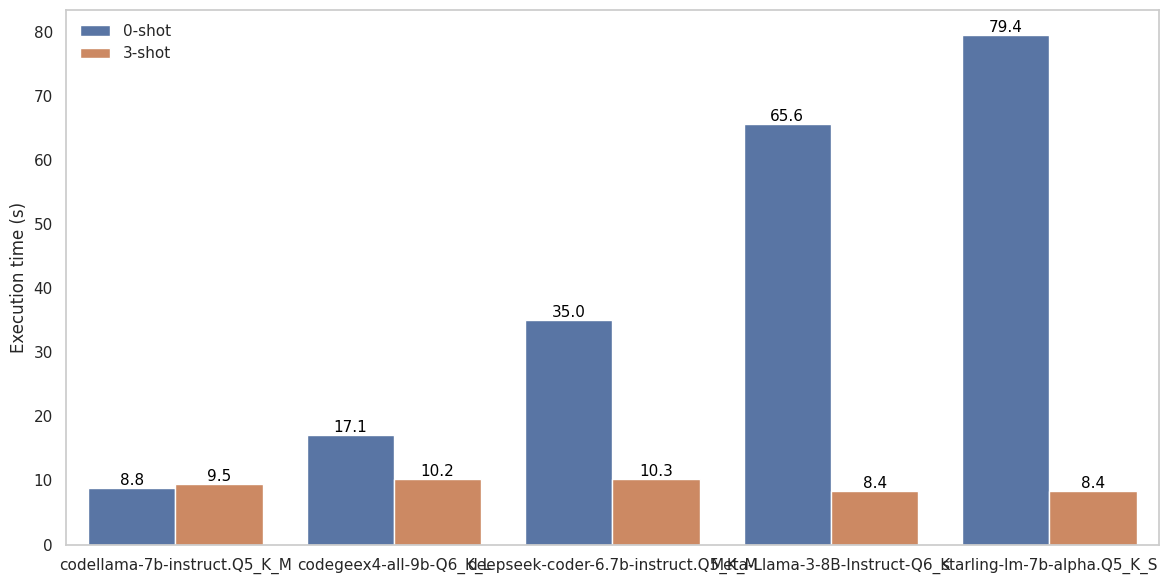

In [133]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Supondo que df_combined_mbpp já esteja declarado conforme mostrado

# Substituir os valores na coluna 'LLM' nos dataframes originais
mapping = {
    "codellama-7b-instruct.Q5_K_M": "codellama",
    "codegeex4-all-9b-Q6_K_L": "codegeex4",
    "deepseek-coder-6.7b-instruct.Q5_K_M": "deepseek-coder",
    "Meta-Llama-3-8B-Instruct-Q6_K": "Meta-Llama-3",
    "starling-lm-7b-alpha.Q5_K_S": "starling-lm"
}

df_0_shot['LLM'] = df_0_shot['LLM'].replace(mapping)
df_3_shot['LLM'] = df_3_shot['LLM'].replace(mapping)

# Filtrando os dados para 0-shot e 3-shot
df_0_shot = df_combined_mbpp[df_combined_mbpp['Shot'] == '0-shot'][['LLM', 'CPU Energy (J)', 'Execution time (s)']]
df_3_shot = df_combined_mbpp[df_combined_mbpp['Shot'] == '3-shot'][['LLM', 'CPU Energy (J)', 'Execution time (s)']]

# Renomeando as colunas para facilitar a plotagem
df_0_shot.rename(columns={'CPU Energy (J)': 'Energy (0-shot)', 'Execution time (s)': 'Execution time (0-shot)'}, inplace=True)
df_3_shot.rename(columns={'CPU Energy (J)': 'Energy (3-shot)', 'Execution time (s)': 'Execution time (3-shot)'}, inplace=True)

# Fazendo um merge dos dois dataframes com base na coluna 'LLM'
df_merged = pd.merge(df_0_shot, df_3_shot, on='LLM')

# Ordenando os dados com base no tempo total de execução (usando média para 0-shot e 3-shot)
df_merged['Total Execution Time'] = df_merged[['Execution time (0-shot)', 'Execution time (3-shot)']].mean(axis=1)
df_sorted = df_merged.sort_values(by='Total Execution Time')

# Transformando os dados para o formato adequado para seaborn
df_melted = df_sorted.melt(id_vars='LLM', value_vars=['Execution time (0-shot)', 'Execution time (3-shot)'], 
                           var_name='Shot', value_name='Execution Time (s)')

# Corrigindo os valores na coluna "Shot" para garantir apenas "0-shot" e "3-shot"
df_melted['Shot'] = df_melted['Shot'].replace({'Execution time (0-shot)': '0-shot', 'Execution time (3-shot)': '3-shot'})

# Definindo o tamanho da figura
plt.figure(figsize=(12, 6))

# Criando o barplot para Execution Time com orientação vertical
barplot = sns.barplot(data=df_melted, x='LLM', y='Execution Time (s)', hue='Shot')

# Configuração dos rótulos e título
plt.ylabel('Execution time (s)', fontsize=12)
plt.xlabel('', fontsize=12)

# Adicionando rótulos às barras
for p in barplot.patches:
    barplot.annotate(f'{p.get_height():.1f}', 
                     (p.get_x() + p.get_width() / 2, p.get_height()), 
                     ha='center', va='bottom', fontsize=11, color='black')

# Configurando a legenda para o barplot
handles1, labels1 = barplot.get_legend_handles_labels()
barplot.legend(handles1, labels1, title='', loc='upper left', bbox_to_anchor=(0, 1), ncol=1, frameon=False)

plt.grid(False)
# Exibindo o gráfico
plt.tight_layout()
#plt.savefig('mbpp_time.pdf', dpi=300, bbox_inches='tight')  # Ajuste o nome e formato conforme necessário
plt.show()


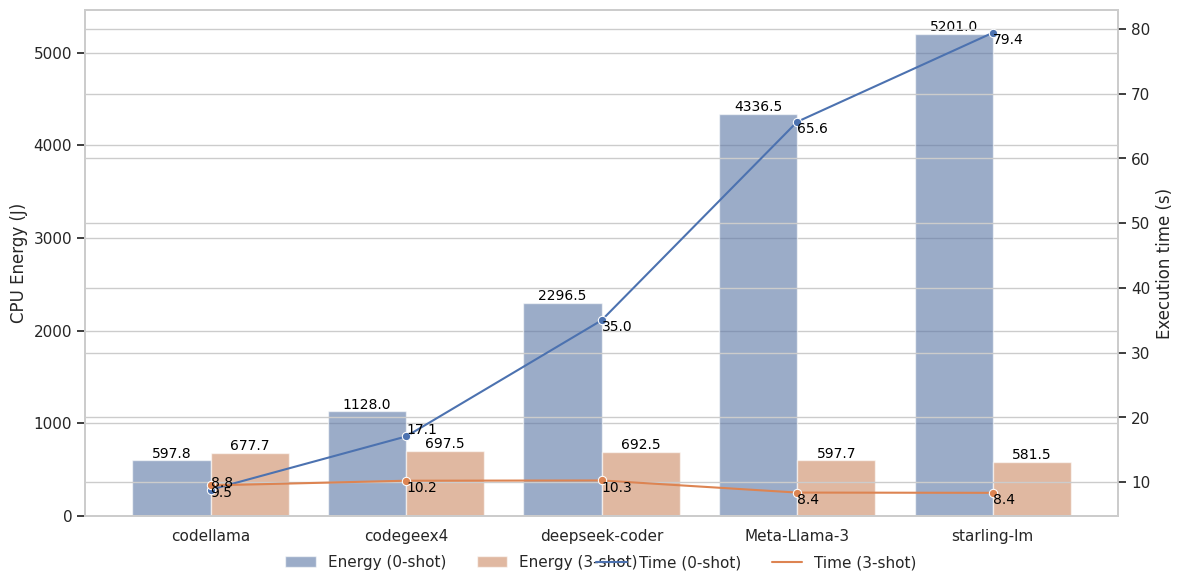

In [134]:
### [PAPER]

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Supondo que df_combined_mbpp já esteja declarado conforme mostrado

# Filtrando os dados para 0-shot e 3-shot
df_0_shot = df_combined_mbpp[df_combined_mbpp['Shot'] == '0-shot'][['LLM', 'CPU Energy (J)', 'Execution time (s)']]
df_3_shot = df_combined_mbpp[df_combined_mbpp['Shot'] == '3-shot'][['LLM', 'CPU Energy (J)', 'Execution time (s)']]

# Substituir os valores na coluna 'LLM' nos dataframes originais
mapping = {
    "codellama-7b-instruct.Q5_K_M": "codellama",
    "codegeex4-all-9b-Q6_K_L": "codegeex4",
    "deepseek-coder-6.7b-instruct.Q5_K_M": "deepseek-coder",
    "Meta-Llama-3-8B-Instruct-Q6_K": "Meta-Llama-3",
    "starling-lm-7b-alpha.Q5_K_S": "starling-lm"
}

df_0_shot['LLM'] = df_0_shot['LLM'].replace(mapping)
df_3_shot['LLM'] = df_3_shot['LLM'].replace(mapping)

# Renomeando as colunas para facilitar a plotagem
df_0_shot.rename(columns={'CPU Energy (J)': 'Energy (0-shot)', 'Execution time (s)': 'Execution time (0-shot)'}, inplace=True)
df_3_shot.rename(columns={'CPU Energy (J)': 'Energy (3-shot)', 'Execution time (s)': 'Execution time (3-shot)'}, inplace=True)

# Fazendo um merge dos dois dataframes com base na coluna 'LLM'
df_merged = pd.merge(df_0_shot, df_3_shot, on='LLM')

# Calculando a média da energia para cada LLM
df_merged['Total Energy'] = df_merged[['Energy (0-shot)', 'Energy (3-shot)']].mean(axis=1)

# Ordenando os dados com base na energia total
df_sorted = df_merged.sort_values(by='Total Energy')

# Definindo o tamanho da figura
plt.figure(figsize=(12, 6))

# Criando um barplot para CPU Energy
barplot = sns.barplot(data=df_sorted.melt(id_vars='LLM', value_vars=['Energy (0-shot)', 'Energy (3-shot)'], var_name='Shot', value_name='CPU Energy'), 
                      x='LLM', y='CPU Energy', hue='Shot', alpha=0.6)

# Adicionando títulos e rótulos
plt.title('')
plt.xlabel('')
plt.ylabel('CPU Energy (J)')

# Adicionando rótulos às barras
for p in barplot.patches:
    barplot.annotate(f'{p.get_height():.1f}', 
                     (p.get_x() + p.get_width() / 2., p.get_height()), 
                     ha='center', va='bottom', 
                     fontsize=10, color='black', 
                     rotation=0)

# Criando um segundo eixo y para Execution time
ax2 = barplot.twinx()

# Plotando o Execution time
sns.lineplot(data=df_sorted.melt(id_vars='LLM', value_vars=['Execution time (0-shot)', 'Execution time (3-shot)']),
             x='LLM', y='value', hue='variable', ax=ax2, marker='o', color='black')


# Adicionando rótulos aos pontos do gráfico de linha
for line_idx, line in enumerate(ax2.get_lines()):
    for x, y in zip(line.get_xdata(), line.get_ydata()):
        llm_label = df_sorted.iloc[int(x)]['LLM']  # Obtém o nome do LLM correspondente
        va_position = 'top'  # Valor padrão

        if llm_label == 'codellama':
            va_position = 'bottom' if line_idx == 0 else 'top'
        if llm_label == 'codegeex4' and line_idx == 0:
            va_position = 'bottom'

        # Adicionando o rótulo com a posição ajustada
        ax2.annotate(f'{y:.1f}', (x, y), ha='left', va=va_position, fontsize=10, color='black')


# Adicionando rótulos e título para o eixo y da direita
ax2.set_ylabel('Execution time (s)')

# Configurando a legenda para o eixo das barras (ax1)
handles1, labels1 = barplot.get_legend_handles_labels()
barplot.legend(handles1, labels1, title='', loc='upper left', bbox_to_anchor=(0.18, -0.05), ncol=2, frameon=False)

# Configurando a legenda para o eixo das linhas (ax2)
handles2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(handles2, ['Time (0-shot)', 'Time (3-shot)'], title='', loc='upper center', bbox_to_anchor=(0.65, -0.05), ncol=2, frameon=False)

# Exibindo o gráfico
plt.tight_layout()

#plt.savefig('mbpp_energy_time.pdf', dpi=300, bbox_inches='tight')  # Ajuste o nome e formato conforme necessário

plt.show()


#### Energy and Time gains

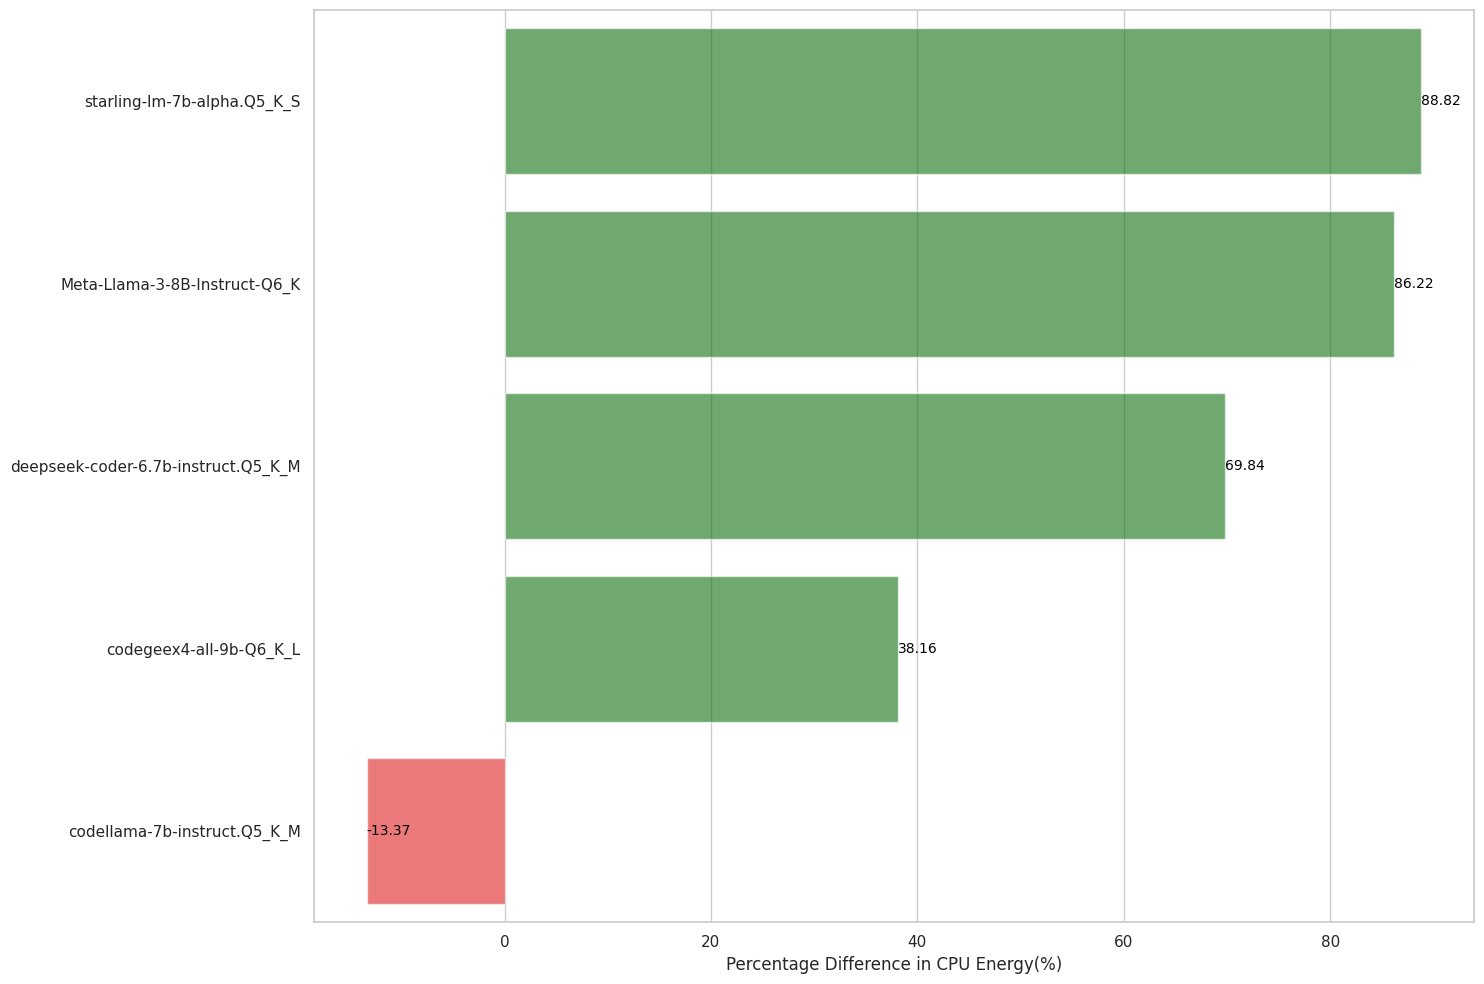

In [135]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Supondo que df_combined_mbpp já esteja declarado conforme mostrado

# Filtrando os dados para 0-shot e 3-shot
df_0_shot = df_combined_mbpp[df_combined_mbpp['Shot'] == '0-shot'][['LLM', 'CPU Energy (J)', 'Execution time (s)']]
df_3_shot = df_combined_mbpp[df_combined_mbpp['Shot'] == '3-shot'][['LLM', 'CPU Energy (J)', 'Execution time (s)']]

# Renomeando as colunas para facilitar a plotagem
df_0_shot.rename(columns={'CPU Energy (J)': 'Energy (0-shot)', 'Execution time (s)': 'Execution time (0-shot)'}, inplace=True)
df_3_shot.rename(columns={'CPU Energy (J)': 'Energy (3-shot)', 'Execution time (s)': 'Execution time (3-shot)'}, inplace=True)

# Fazendo um merge dos dois dataframes com base na coluna 'LLM'
df_merged = pd.merge(df_0_shot, df_3_shot, on='LLM')

# Calculando o ganho percentual de energia de 0-shot para 3-shot
df_merged['Energy Gain (%)'] = ((df_merged['Energy (0-shot)'] - df_merged['Energy (3-shot)']) / df_merged['Energy (0-shot)']) * 100

# Ordenando os dados com base no ganho percentual de energia (de maior ganho para menor)
df_sorted = df_merged.sort_values(by='Energy Gain (%)', ascending=False)

# Definindo as cores com base nos ganhos (verde para ganhos positivos, vermelho para negativos)
colors = ['green' if val > 0 else 'red' for val in df_sorted['Energy Gain (%)']]

# Definindo o tamanho da figura
plt.figure(figsize=(15, 10))


# Criando um barplot para o ganho percentual de CPU Energy, usando as cores definidas
barplot = sns.barplot(data=df_sorted, y='LLM', x='Energy Gain (%)', palette=colors, alpha=0.6)

# Adicionando títulos e rótulos
#plt.title('CPU Energy Gain Percentage (0-shot vs 3-shot) for LLMs - MBPP', fontsize=14)
plt.xlabel('Percentage Difference in CPU Energy(%)', fontsize=12)
plt.ylabel('', fontsize=12)

# Adicionando rótulos às barras (valores percentuais de ganho com duas casas decimais)
for p in barplot.patches:
    barplot.annotate(f'{p.get_width():.2f}', 
                     (p.get_width(), p.get_y() + p.get_height() / 2), 
                     ha='left', va='center', 
                     fontsize=10, color='black', 
                     rotation=0)

# Exibindo o gráfico
plt.tight_layout()
#plt.savefig("mbpp_energy_gain_percentage.png")
plt.show()


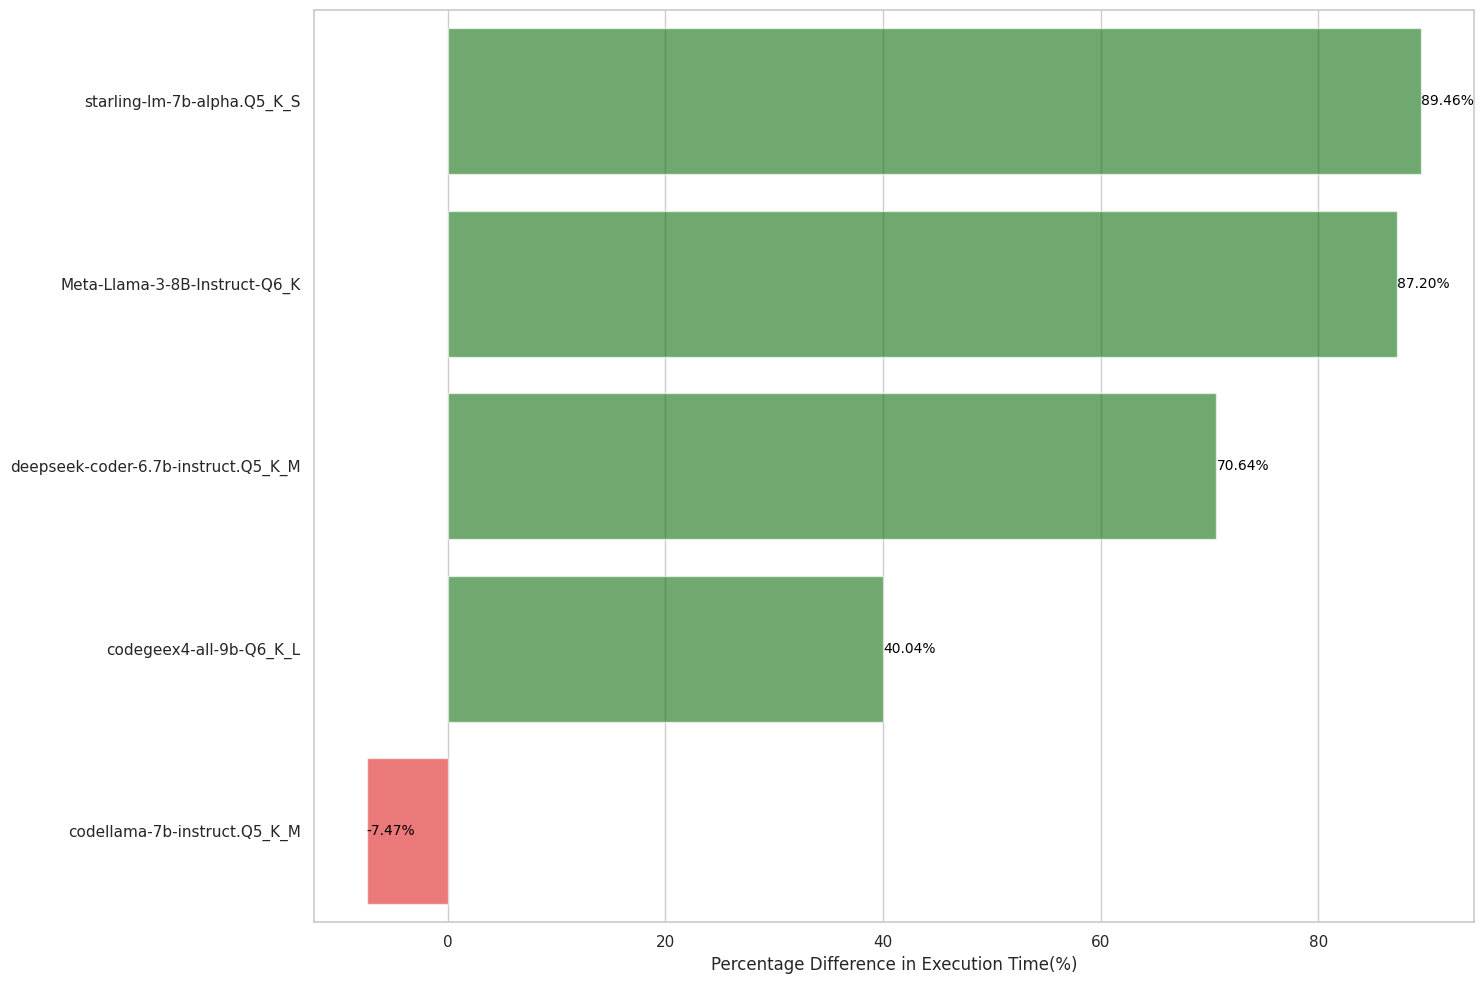

In [136]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Supondo que df_combined_mbpp já esteja declarado conforme mostrado

# Filtrando os dados para 0-shot e 3-shot
df_0_shot = df_combined_mbpp[df_combined_mbpp['Shot'] == '0-shot'][['LLM', 'CPU Energy (J)', 'Execution time (s)']]
df_3_shot = df_combined_mbpp[df_combined_mbpp['Shot'] == '3-shot'][['LLM', 'CPU Energy (J)', 'Execution time (s)']]

# Renomeando as colunas para facilitar a plotagem
df_0_shot.rename(columns={'CPU Energy (J)': 'Energy (0-shot)', 'Execution time (s)': 'Execution time (0-shot)'}, inplace=True)
df_3_shot.rename(columns={'CPU Energy (J)': 'Energy (3-shot)', 'Execution time (s)': 'Execution time (3-shot)'}, inplace=True)

# Fazendo um merge dos dois dataframes com base na coluna 'LLM'
df_merged = pd.merge(df_0_shot, df_3_shot, on='LLM')

# Calculando o ganho percentual de tempo de execução de 0-shot para 3-shot
df_merged['Execution Time Gain (%)'] = ((df_merged['Execution time (0-shot)'] - df_merged['Execution time (3-shot)']) / df_merged['Execution time (0-shot)']) * 100

# Ordenando os dados com base no ganho percentual de tempo (de maior ganho para menor)
df_sorted = df_merged.sort_values(by='Execution Time Gain (%)', ascending=False)

# Definindo as cores com base nos ganhos (verde para ganhos positivos, vermelho para negativos)
colors = ['green' if val > 0 else 'red' for val in df_sorted['Execution Time Gain (%)']]

# Definindo o tamanho da figura
plt.figure(figsize=(15, 10))

# Criando um barplot para o ganho percentual de Execution Time, usando as cores definidas
barplot = sns.barplot(data=df_sorted, y='LLM', x='Execution Time Gain (%)', palette=colors, alpha=0.6)

# Adicionando títulos e rótulos
#plt.title('Execution Time Gain Percentage (0-shot vs 3-shot) for LLMs - MBPP', fontsize=14)
plt.xlabel('Percentage Difference in Execution Time(%)', fontsize=12)
plt.ylabel('', fontsize=12)

# Adicionando rótulos às barras (valores percentuais de ganho com duas casas decimais)
for p in barplot.patches:
    barplot.annotate(f'{p.get_width():.2f}%', 
                     (p.get_width(), p.get_y() + p.get_height() / 2), 
                     ha='left', va='center', 
                     fontsize=10, color='black', 
                     rotation=0)

# Exibindo o gráfico
plt.tight_layout()
#plt.savefig("mbpp_execution_time_gain_percentage.png")
plt.show()


#### Pass@k vs BLEU

In [137]:
df_combined_mbpp

,LLM,Execution time (s),CPU Energy (J),MBPP (unsanitized) pass@1,MBPP+ (unsanitized) pass@1,MBPP (sanitized) pass@1,MBPP+ (sanitized) pass@1,MBPP (unsanitized) pass@10,MBPP+ (unsanitized) pass@10,MBPP (sanitized) pass@10,MBPP+ (sanitized) pass@10,GoogleBLEU (unsanitized),CodeBLEU (unsanitized),SacreBLEU (unsanitized),GoogleBLEU (sanitized),CodeBLEU (sanitized),SacreBLEU (sanitized),Shot
0,Meta-Llama-3-8B-Instruct-Q6_K,65.649756,4336.466439,0.654000,0.542000,0.686000,0.569000,0.835000,0.725000,0.837000,0.728000,0.069140,0.315794,0.062450,0.168783,0.244199,0.185539,0-shot
1,codegeex4-all-9b-Q6_K_L,17.069976,1127.984104,0.000000,0.000000,0.274000,0.212000,0.000000,0.000000,0.595000,0.489000,0.192322,0.309949,0.179499,0.176930,0.189083,0.176504,0-shot
2,codellama-7b-instruct.Q5_K_M,8.847133,597.782381,0.193000,0.167000,0.610000,0.517000,0.685000,0.595000,0.873000,0.767000,0.101692,0.327037,0.091833,0.255243,0.260233,0.273627,0-shot
3,deepseek-coder-6.7b-instruct.Q5_K_M,35.003395,2296.474371,0.193000,0.167000,0.610000,0.517000,0.685000,0.595000,0.873000,0.767000,0.101692,0.327037,0.091833,0.255243,0.260233,0.273627,0-shot
4,starling-lm-7b-alpha.Q5_K_S,79.387905,5201.048618,0.074000,0.060000,0.428000,0.354000,0.444000,0.370000,0.820000,0.698000,0.043459,0.325714,0.037512,0.191784,0.232059,0.223515,0-shot
5,Meta-Llama-3-8B-Instruct-Q6_K,8.404732,597.672158,0.189239,0.163618,0.604247,0.511848,0.677383,0.587888,0.871325,0.764819,0.187449,0.325431,0.182965,0.318473,0.308447,0.336522,3-shot
6,codegeex4-all-9b-Q6_K_L,10.235238,697.542414,0.003005,0.002600,0.279231,0.216749,0.010665,0.009264,0.599328,0.493328,0.249802,0.301452,0.247107,0.261156,0.263478,0.286512,3-shot
7,codellama-7b-instruct.Q5_K_M,9.508065,677.677904,0.096343,0.078567,0.437939,0.362282,0.459062,0.383675,0.820655,0.699156,0.072520,0.293982,0.064890,0.226153,0.252981,0.248980,3-shot
8,deepseek-coder-6.7b-instruct.Q5_K_M,10.275680,692.523864,0.000000,0.000000,0.274000,0.212000,0.000000,0.000000,0.595000,0.489000,0.232791,0.303344,0.226073,0.239567,0.244764,0.259863,3-shot
9,starling-lm-7b-alpha.Q5_K_S,8.364644,581.524990,0.193000,0.167000,0.610000,0.517000,0.685000,0.595000,0.873000,0.767000,0.156937,0.324664,0.149289,0.304495,0.297625,0.322965,3-shot


#### [PAPER] Pass@1 and Pass@10

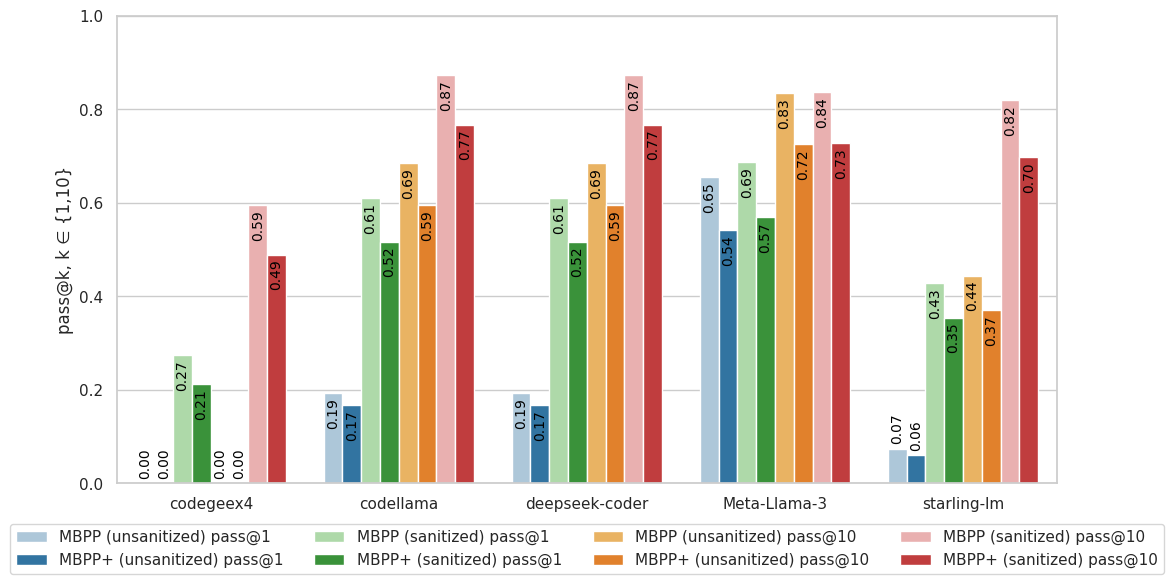

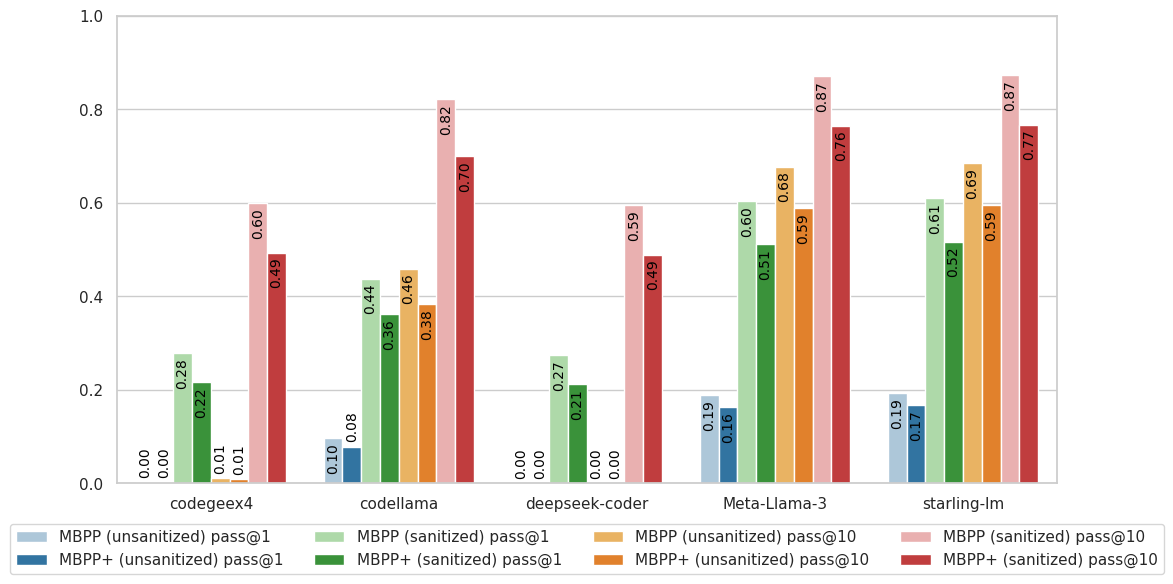

In [138]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Ordem personalizada para a coluna 'LLM' (novos valores)
llm_order = [
    "codegeex4",
    "codellama",
    "deepseek-coder",
    "Meta-Llama-3",
    "starling-lm"
]

# Substituir os valores na coluna 'LLM' nos dataframes originais
mapping = {
    "codegeex4-all-9b-Q6_K_L": "codegeex4",
    "codellama-7b-instruct.Q5_K_M": "codellama",
    "deepseek-coder-6.7b-instruct.Q5_K_M": "deepseek-coder",
    "Meta-Llama-3-8B-Instruct-Q6_K": "Meta-Llama-3",
    "starling-lm-7b-alpha.Q5_K_S": "starling-lm"
}

df_combined_mbpp['LLM'] = df_combined_mbpp['LLM'].replace(mapping)

# Converter a coluna 'LLM' para uma categoria ordenada
df_combined_mbpp['LLM'] = pd.Categorical(df_combined_mbpp['LLM'], categories=llm_order, ordered=True)

# Melt the DataFrames for unsanitized metrics
df_melted_unsanitized = df_combined_mbpp.melt(
    id_vars=['LLM', 'Shot'], 
    value_vars=[
        'MBPP (unsanitized) pass@1',
        'MBPP+ (unsanitized) pass@1',
        'MBPP (unsanitized) pass@10',
        'MBPP+ (unsanitized) pass@10'
    ], 
    var_name='Metric', 
    value_name='Score'
)

# Melt the DataFrames for sanitized metrics
df_melted_sanitized = df_combined_mbpp.melt(
    id_vars=['LLM', 'Shot'], 
    value_vars=[
        'MBPP (sanitized) pass@1',
        'MBPP+ (sanitized) pass@1',
        'MBPP (sanitized) pass@10',
        'MBPP+ (sanitized) pass@10'
    ], 
    var_name='Metric', 
    value_name='Score'
)

# Add 'Type' column to distinguish between metric types
df_melted_unsanitized['Type'] = 'Unsanitized'
df_melted_sanitized['Type'] = 'Sanitized'

# Combine the melted DataFrames
df_combined_melted = pd.concat([df_melted_unsanitized, df_melted_sanitized], ignore_index=True)

# Filter for 0-shot data for the left plot
df_combined_0_shot = df_combined_melted[df_combined_melted["Shot"] == "0-shot"]

# Filter for 3-shot data for the right plot
df_combined_3_shot = df_combined_melted[df_combined_melted["Shot"] == "3-shot"]

# Define a combined custom palette
combined_palette = {
    'MBPP (unsanitized) pass@1': '#a6c8e0',  # Light blue
    'MBPP+ (unsanitized) pass@1': '#1f77b4', # Dark blue
    'MBPP (unsanitized) pass@10': '#ffb84d', # Light orange
    'MBPP+ (unsanitized) pass@10': '#ff7f0e', # Dark orange
    'MBPP (sanitized) pass@1': '#a8e1a1',    # Light green
    'MBPP+ (sanitized) pass@1': '#2ca02c',   # Dark green
    'MBPP (sanitized) pass@10': '#f2a6a6',   # Light red
    'MBPP+ (sanitized) pass@10': '#d62728'   # Dark red
}

# Create a new DataFrame with ordered metrics
metric_order = [
    'MBPP (unsanitized) pass@1',
    'MBPP+ (unsanitized) pass@1',
    'MBPP (sanitized) pass@1',
    'MBPP+ (sanitized) pass@1',
    'MBPP (unsanitized) pass@10',
    'MBPP+ (unsanitized) pass@10',
    'MBPP (sanitized) pass@10',
    'MBPP+ (sanitized) pass@10'
]

# Plot for 0-shot metrics
fig_0_shot = plt.figure(figsize=(12, 6))
sns.barplot(
    data=df_combined_0_shot,
    x='LLM',
    y='Score',
    hue='Metric',
    ci=None,
    palette=combined_palette,
    dodge=True,
    hue_order=metric_order
)
plt.title('')
plt.xlabel('')
plt.ylabel('pass@k, k ∈ {1,10}')
plt.ylim(0, 1)

# Add annotations for values in the 0-shot plot
for p in plt.gca().patches:
    value = p.get_height()
    if value < 0.08:
        va = 'bottom'
        y_offset = 0.01
    else:
        va = 'top'
        y_offset = -0.01
    plt.gca().text(p.get_x() + p.get_width() / 2, value + y_offset, f'{value:.2f}', 
                   ha='center', va=va, rotation=90, fontsize=10, color='black')

plt.legend(title='', loc='upper center', bbox_to_anchor=(0.5, -0.07), ncol=4)
# Save the 0-shot plot to a file
plt.tight_layout()
#plt.savefig('mbpp_metrics_0_shot.pdf', dpi=300, bbox_inches='tight')
plt.show()
plt.close(fig_0_shot)

# Plot for 3-shot metrics
fig_3_shot = plt.figure(figsize=(12, 6))
sns.barplot(
    data=df_combined_3_shot,
    x='LLM',
    y='Score',
    hue='Metric',
    ci=None,
    palette=combined_palette,
    dodge=True,
    hue_order=metric_order
)
plt.title('')
plt.xlabel('')
plt.ylabel('')
plt.ylim(0, 1)

# Add annotations for values in the 3-shot plot
for p in plt.gca().patches:
    value = p.get_height()
    if value < 0.08:
        va = 'bottom'
        y_offset = 0.01
    else:
        va = 'top'
        y_offset = -0.01
    plt.gca().text(p.get_x() + p.get_width() / 2, value + y_offset, f'{value:.2f}', 
                   ha='center', va=va, rotation=90, fontsize=10, color='black')

plt.legend(title='', loc='upper center', bbox_to_anchor=(0.5, -0.07), ncol=4)
# Save the 3-shot plot to a file
plt.tight_layout()
#plt.savefig('mbpp_metrics_3_shot.pdf', dpi=300, bbox_inches='tight')
plt.show()
plt.close(fig_3_shot)


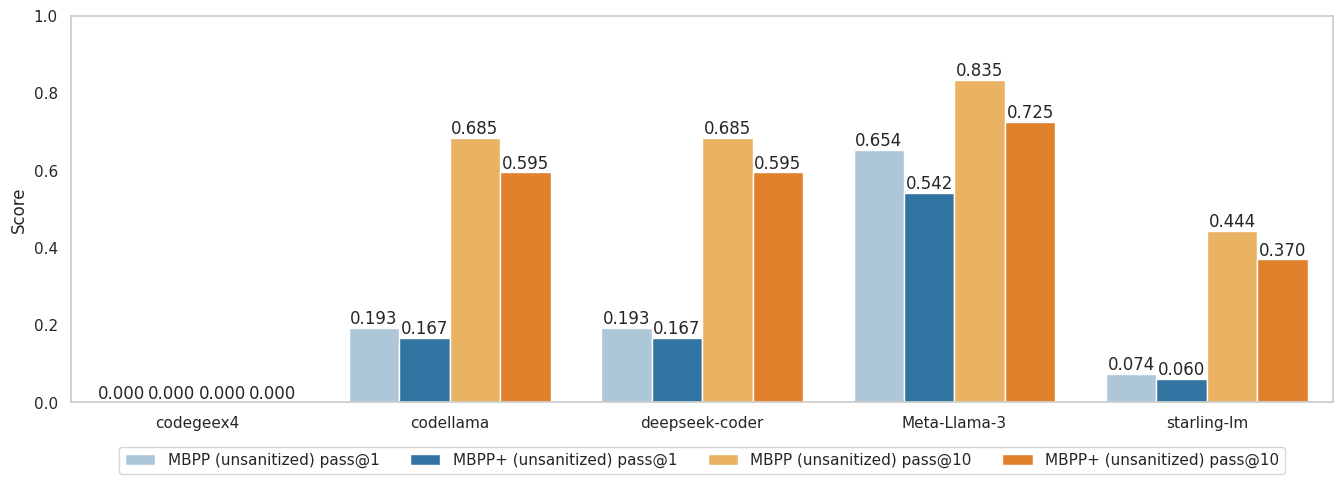

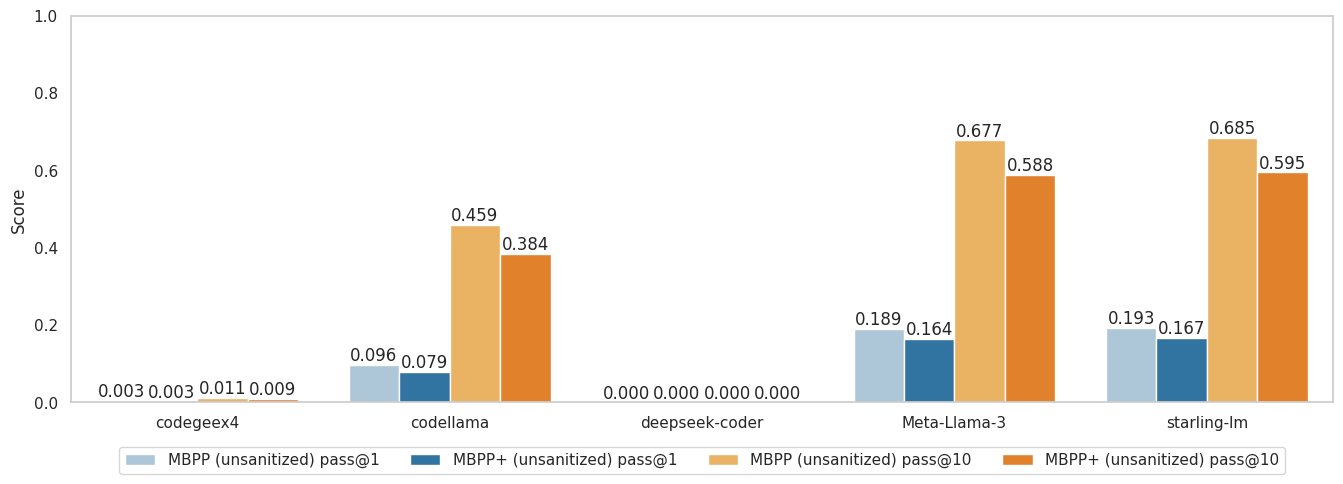

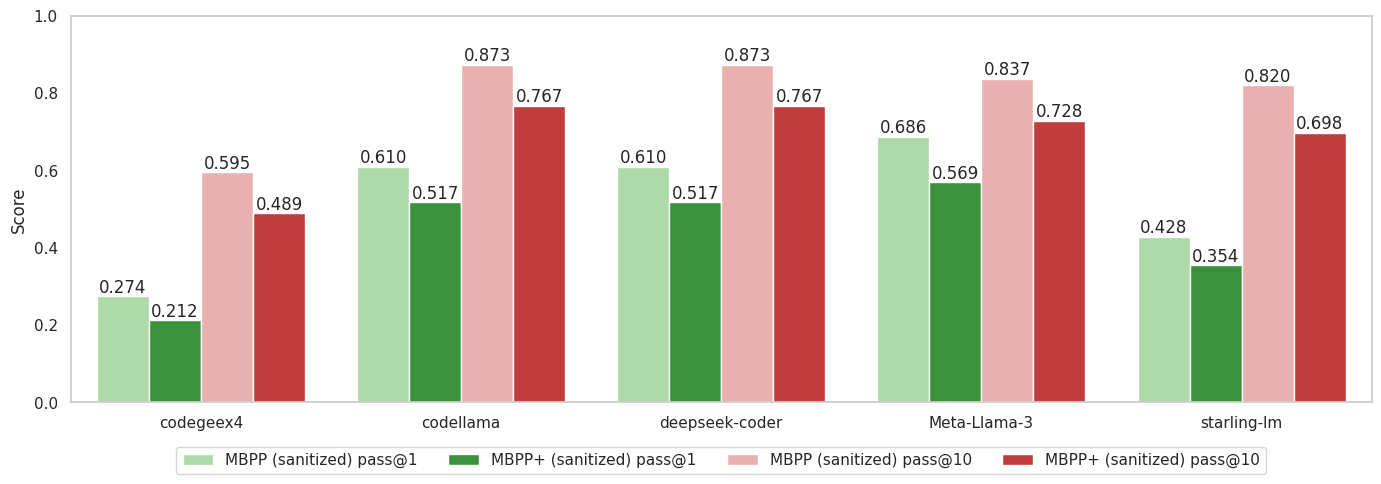

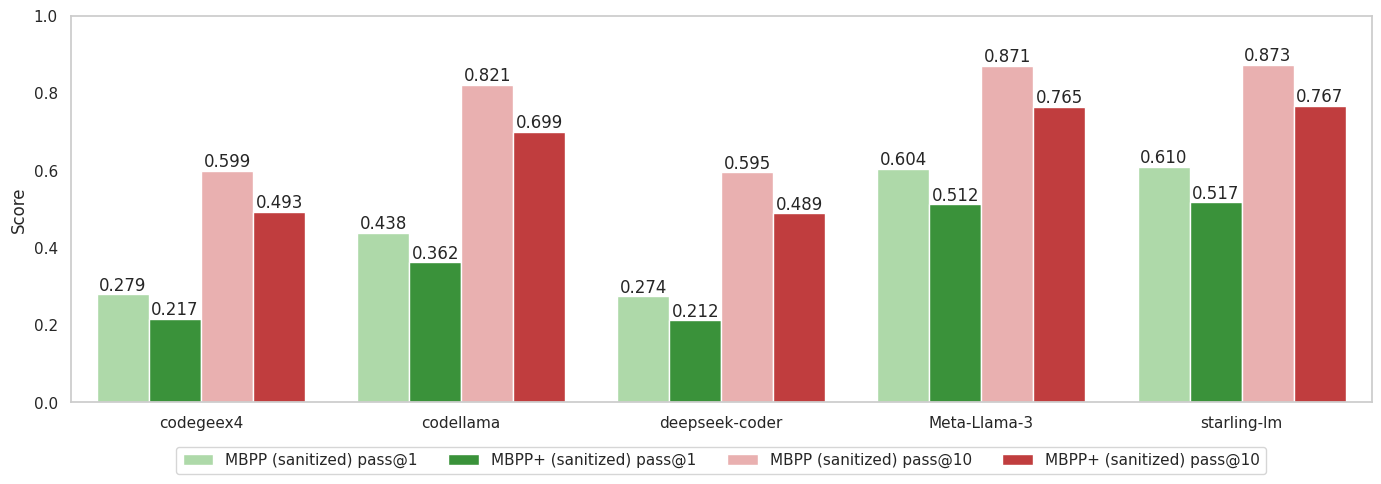

In [139]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Assuming df_combined_mbpp is already defined

# Melt the DataFrame for unsanitized metrics
df_melted_unsanitized = df_combined_mbpp.melt(
    id_vars=['LLM', 'Shot'], 
    value_vars=[
        'MBPP (unsanitized) pass@1',
        'MBPP+ (unsanitized) pass@1',
        'MBPP (unsanitized) pass@10',
        'MBPP+ (unsanitized) pass@10'
    ], 
    var_name='Metric', 
    value_name='Score'
)

# Melt the DataFrame for sanitized metrics
df_melted_sanitized = df_combined_mbpp.melt(
    id_vars=['LLM', 'Shot'], 
    value_vars=[
        'MBPP (sanitized) pass@1',
        'MBPP+ (sanitized) pass@1',
        'MBPP (sanitized) pass@10',
        'MBPP+ (sanitized) pass@10'
    ], 
    var_name='Metric', 
    value_name='Score'
)

# Define custom palettes for unsanitized and sanitized metrics
palette_unsanitized = {
    'MBPP (unsanitized) pass@1': '#a6c8e0',   # Light blue
    'MBPP+ (unsanitized) pass@1': '#1f77b4',  # Dark blue
    'MBPP (unsanitized) pass@10': '#ffb84d',  # Light orange
    'MBPP+ (unsanitized) pass@10': '#ff7f0e'  # Dark orange
}

palette_sanitized = {
    'MBPP (sanitized) pass@1': '#a8e1a1',   # Light green
    'MBPP+ (sanitized) pass@1': '#2ca02c',  # Dark green
    'MBPP (sanitized) pass@10': '#f2a6a6',  # Light red
    'MBPP+ (sanitized) pass@10': '#d62728'  # Dark red
}

# Function to plot metrics by "Shot"
def plot_metrics_by_shot(df_melted, palette, shot, metric_type):
    plt.figure(figsize=(14, 5))
    
    # Filter the DataFrame by the shot
    df_shot = df_melted[df_melted['Shot'] == shot]
    
    ax = sns.barplot(data=df_shot, x='LLM', y='Score', hue='Metric', ci=None, palette=palette, dodge=True)

    #plt.title(f"{metric_type} MBPP and MBPP+ Metrics for {shot} Prompting")
    plt.xlabel("")
    plt.ylabel("Score")
    plt.ylim(0, 1)

    # Add labels on top of the bars
    for p in ax.patches:
        ax.annotate(f'{p.get_height():.3f}', 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha='center', va='bottom')

    # Place the legend below the plot and centered
    plt.legend(title=None, bbox_to_anchor=(0.5, -0.15), loc='center', ncol=4)
    
    plt.grid(False)
    plt.tight_layout()
    #plt.savefig(f"mbpp_{shot}_{metric_type}.png")
    plt.show()

# Plot unsanitized metrics for each shot
for shot in df_combined_mbpp['Shot'].unique():
    plot_metrics_by_shot(df_melted_unsanitized, palette_unsanitized, shot, "Unsanitized")

# Plot sanitized metrics for each shot
for shot in df_combined_mbpp['Shot'].unique():
    plot_metrics_by_shot(df_melted_sanitized, palette_sanitized, shot, "Sanitized")


#### BLEU

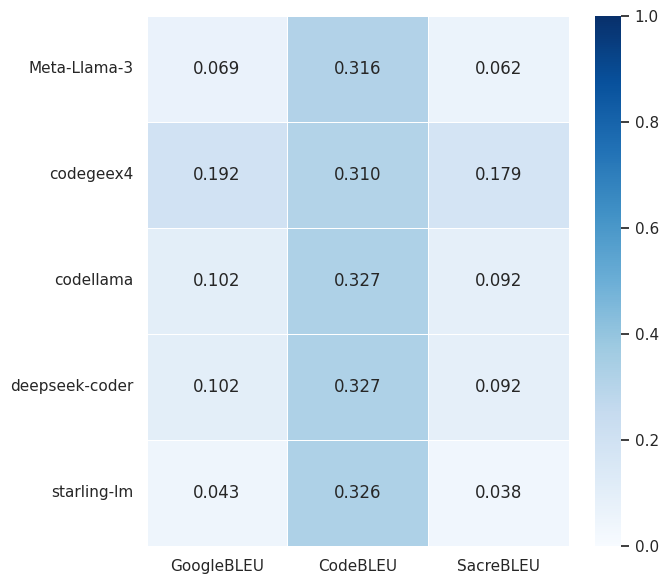

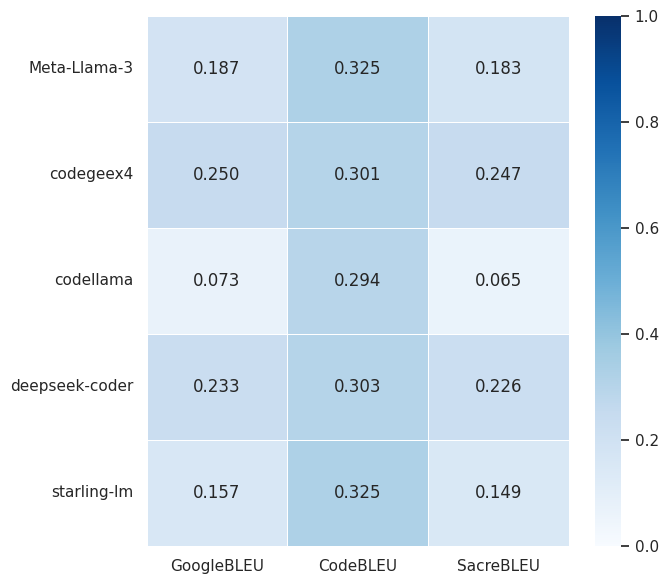

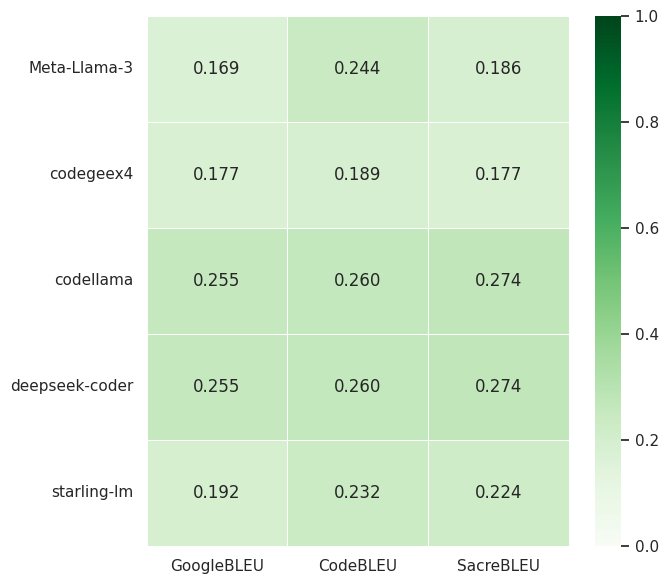

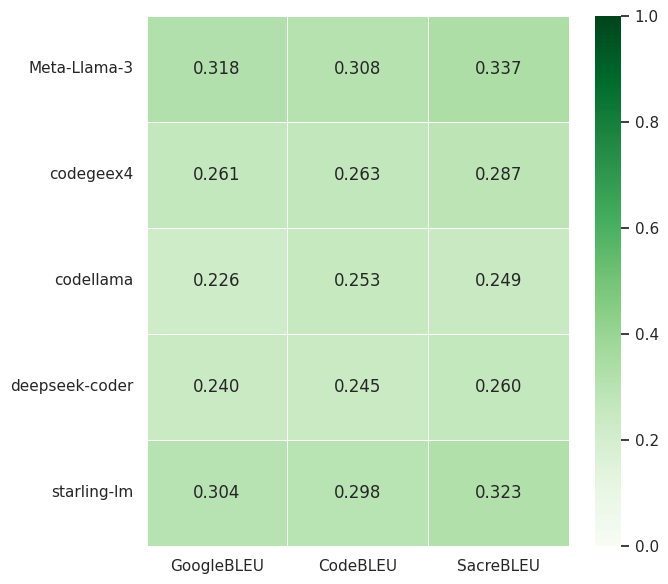

In [140]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Assuming df_combined_mbpp is already defined

# Filter DataFrames for unsanitized BLEU metrics
df_bleu_unsanitized_0shot = df_combined_mbpp[df_combined_mbpp['Shot'] == '0-shot'][['LLM', 'GoogleBLEU (unsanitized)', 'CodeBLEU (unsanitized)', 'SacreBLEU (unsanitized)']]
df_bleu_unsanitized_0shot.columns = ['LLM', 'GoogleBLEU', 'CodeBLEU', 'SacreBLEU']  # Rename columns
df_bleu_unsanitized_0shot = df_bleu_unsanitized_0shot.set_index('LLM')

df_bleu_unsanitized_3shot = df_combined_mbpp[df_combined_mbpp['Shot'] == '3-shot'][['LLM', 'GoogleBLEU (unsanitized)', 'CodeBLEU (unsanitized)', 'SacreBLEU (unsanitized)']]
df_bleu_unsanitized_3shot.columns = ['LLM', 'GoogleBLEU', 'CodeBLEU', 'SacreBLEU']  # Rename columns
df_bleu_unsanitized_3shot = df_bleu_unsanitized_3shot.set_index('LLM')

# Filter DataFrames for sanitized BLEU metrics
df_bleu_sanitized_0shot = df_combined_mbpp[df_combined_mbpp['Shot'] == '0-shot'][['LLM', 'GoogleBLEU (sanitized)', 'CodeBLEU (sanitized)', 'SacreBLEU (sanitized)']]
df_bleu_sanitized_0shot.columns = ['LLM', 'GoogleBLEU', 'CodeBLEU', 'SacreBLEU']  # Rename columns
df_bleu_sanitized_0shot = df_bleu_sanitized_0shot.set_index('LLM')

df_bleu_sanitized_3shot = df_combined_mbpp[df_combined_mbpp['Shot'] == '3-shot'][['LLM', 'GoogleBLEU (sanitized)', 'CodeBLEU (sanitized)', 'SacreBLEU (sanitized)']]
df_bleu_sanitized_3shot.columns = ['LLM', 'GoogleBLEU', 'CodeBLEU', 'SacreBLEU']  # Rename columns
df_bleu_sanitized_3shot = df_bleu_sanitized_3shot.set_index('LLM')

width = 7
height = 6

# Create heatmap for unsanitized BLEU metrics - 0-shot
plt.figure(figsize=(width, height))
sns.heatmap(df_bleu_unsanitized_0shot, annot=True, cmap='Blues', fmt='.3f', linewidths=0.5, vmin=0, vmax=1)
#plt.title('Unsanitized BLEU Metrics (0-shot) by LLM')
plt.xlabel('')
plt.ylabel('')
plt.ylim(len(df_bleu_unsanitized_0shot), 0)  # Reverse y-axis for better visual
plt.tight_layout()
#plt.savefig("unsanitized_0shot_bleu_mbpp.png")
plt.show()

# Create heatmap for unsanitized BLEU metrics - 3-shot
plt.figure(figsize=(width, height))
sns.heatmap(df_bleu_unsanitized_3shot, annot=True, cmap='Blues', fmt='.3f', linewidths=0.5, vmin=0, vmax=1)
#plt.title('Unsanitized BLEU Metrics (3-shot) by LLM')
plt.xlabel('')
plt.ylabel('')
plt.ylim(len(df_bleu_unsanitized_3shot), 0)  # Reverse y-axis for better visual
plt.tight_layout()
#plt.savefig("unsanitized_3shot_bleu_mbpp.png")
plt.show()

# Create heatmap for sanitized BLEU metrics - 0-shot
plt.figure(figsize=(width, height))
sns.heatmap(df_bleu_sanitized_0shot, annot=True, cmap='Greens', fmt='.3f', linewidths=0.5, vmin=0, vmax=1)
#plt.title('Sanitized BLEU Metrics (0-shot) by LLM')
plt.xlabel('')
plt.ylabel('')
plt.ylim(len(df_bleu_sanitized_0shot), 0)  # Reverse y-axis for better visual
plt.tight_layout()
#plt.savefig("sanitized_0shot_bleu_mbpp.png")
plt.show()

# Create heatmap for sanitized BLEU metrics - 3-shot
plt.figure(figsize=(width, height))
sns.heatmap(df_bleu_sanitized_3shot, annot=True, cmap='Greens', fmt='.3f', linewidths=0.5, vmin=0, vmax=1)
#plt.title('Sanitized BLEU Metrics (3-shot) by LLM')
plt.xlabel('')
plt.ylabel('')
plt.ylim(len(df_bleu_sanitized_3shot), 0)  # Reverse y-axis for better visual
plt.tight_layout()
#plt.savefig("sanitized_3shot_bleu_mbpp.png")
plt.show()


### LLM Ranking

In [141]:
df_combined_mbpp

,LLM,Execution time (s),CPU Energy (J),MBPP (unsanitized) pass@1,MBPP+ (unsanitized) pass@1,MBPP (sanitized) pass@1,MBPP+ (sanitized) pass@1,MBPP (unsanitized) pass@10,MBPP+ (unsanitized) pass@10,MBPP (sanitized) pass@10,MBPP+ (sanitized) pass@10,GoogleBLEU (unsanitized),CodeBLEU (unsanitized),SacreBLEU (unsanitized),GoogleBLEU (sanitized),CodeBLEU (sanitized),SacreBLEU (sanitized),Shot
0,Meta-Llama-3,65.649756,4336.466439,0.654000,0.542000,0.686000,0.569000,0.835000,0.725000,0.837000,0.728000,0.069140,0.315794,0.062450,0.168783,0.244199,0.185539,0-shot
1,codegeex4,17.069976,1127.984104,0.000000,0.000000,0.274000,0.212000,0.000000,0.000000,0.595000,0.489000,0.192322,0.309949,0.179499,0.176930,0.189083,0.176504,0-shot
2,codellama,8.847133,597.782381,0.193000,0.167000,0.610000,0.517000,0.685000,0.595000,0.873000,0.767000,0.101692,0.327037,0.091833,0.255243,0.260233,0.273627,0-shot
3,deepseek-coder,35.003395,2296.474371,0.193000,0.167000,0.610000,0.517000,0.685000,0.595000,0.873000,0.767000,0.101692,0.327037,0.091833,0.255243,0.260233,0.273627,0-shot
4,starling-lm,79.387905,5201.048618,0.074000,0.060000,0.428000,0.354000,0.444000,0.370000,0.820000,0.698000,0.043459,0.325714,0.037512,0.191784,0.232059,0.223515,0-shot
5,Meta-Llama-3,8.404732,597.672158,0.189239,0.163618,0.604247,0.511848,0.677383,0.587888,0.871325,0.764819,0.187449,0.325431,0.182965,0.318473,0.308447,0.336522,3-shot
6,codegeex4,10.235238,697.542414,0.003005,0.002600,0.279231,0.216749,0.010665,0.009264,0.599328,0.493328,0.249802,0.301452,0.247107,0.261156,0.263478,0.286512,3-shot
7,codellama,9.508065,677.677904,0.096343,0.078567,0.437939,0.362282,0.459062,0.383675,0.820655,0.699156,0.072520,0.293982,0.064890,0.226153,0.252981,0.248980,3-shot
8,deepseek-coder,10.275680,692.523864,0.000000,0.000000,0.274000,0.212000,0.000000,0.000000,0.595000,0.489000,0.232791,0.303344,0.226073,0.239567,0.244764,0.259863,3-shot
9,starling-lm,8.364644,581.524990,0.193000,0.167000,0.610000,0.517000,0.685000,0.595000,0.873000,0.767000,0.156937,0.324664,0.149289,0.304495,0.297625,0.322965,3-shot


#### LLMs gain ranking

In [142]:
DATAFRAMES_WITHOUT_OUTLIERS_TO_CSV = False

if DATAFRAMES_WITHOUT_OUTLIERS_TO_CSV == True:
    # Add the "N_SHOT" column using .loc
    df_0_no_outliers.loc[:, "N_SHOT"] = "0-shot"
    df_3_no_outliers.loc[:, "N_SHOT"] = "3-shot"
    
    # Combine the two tables into a single DataFrame
    df_table = pd.concat([df_0_no_outliers, df_3_no_outliers], ignore_index=True)
    
    # Save df_table to a CSV file
    df_table.to_csv('df_table_mbpp.csv', index=False)


##### LLMs 0-shot ranking

In [143]:
df_0_no_outliers.columns

Index(['LLM', 'Benchmark prompt', 'Execution time (s)', 'CPU Energy (J)',
       'RAM Energy (J)', 'GPU Energy (J)', 'CPU Power (W)', 'RAM Power (W)',
       'GPU Power (W)', 'CO2 emissions (Kg)', 'CO2 emissions rate (Kg/s)',
       'MBPP (unsanitized) pass@1', 'MBPP+ (unsanitized) pass@1',
       'MBPP (sanitized) pass@1', 'MBPP+ (sanitized) pass@1',
       'MBPP (unsanitized) pass@10', 'MBPP+ (unsanitized) pass@10',
       'MBPP (sanitized) pass@10', 'MBPP+ (sanitized) pass@10',
       'GoogleBLEU (unsanitized)', 'CodeBLEU (unsanitized)',
       'SacreBLEU (unsanitized)', 'GoogleBLEU (sanitized)',
       'CodeBLEU (sanitized)', 'SacreBLEU (sanitized)', 'Origin'],
      dtype='object')

In [144]:
import pandas as pd

# Supondo que df_0_table já esteja carregado com as colunas corretas

# Calcular a média para cada LLM
df_mean_metrics = df_0_no_outliers.groupby('LLM').agg({
    'CPU Energy (J)': 'mean',
    'Execution time (s)': 'mean'
}).reset_index()

# Ordenar o DataFrame pela coluna 'CPU Energy (J)' em ordem crescente para o ranking de consumo de energia
df_ranked = df_mean_metrics.sort_values(by='CPU Energy (J)')

# Criar uma coluna de ranking com base na CPU Energy, em ordem crescente
df_ranked['Rank'] = df_ranked['CPU Energy (J)'].rank(ascending=True, method='min').astype(int)

# Calcular as razões em relação ao primeiro lugar
first_energy = df_ranked['CPU Energy (J)'].iloc[0]
first_time = df_ranked['Execution time (s)'].iloc[0]

df_ranked['Energy Ratio'] = df_ranked['CPU Energy (J)'] / first_energy
df_ranked['Time Ratio'] = df_ranked['Execution time (s)'] / first_time

# Reorganizar as colunas para melhor visualização
df_ranked = df_ranked[['Rank', 'LLM', 
                        'Energy Ratio', 'Time Ratio', 
                        'CPU Energy (J)', 'Execution time (s)'
                        ]]

# Renomear as colunas para melhor clareza
df_ranked.columns = ['Rank', 'LLM', 
                     'Energy Ratio (compared to 1st)', 
                     'Time Ratio (compared to 1st)', 
                     'CPU Energy (J)', 'Execution Time (s)']

# Exibir o ranking final
df_ranked.style.hide_index()


/tmp/ipykernel_6018/1362867744.py:37: FutureWarning: this method is deprecated in favour of `Styler.hide(axis='index')`
  df_ranked.style.hide_index()


Rank,LLM,Energy Ratio (compared to 1st),Time Ratio (compared to 1st),CPU Energy (J),Execution Time (s)
1,codellama-7b-instruct.Q5_K_M,1.000000,1.000000,597.782381,8.847133
2,codegeex4-all-9b-Q6_K_L,1.886948,1.929436,1127.984104,17.069976
3,deepseek-coder-6.7b-instruct.Q5_K_M,3.841656,3.956468,2296.474371,35.003395
4,Meta-Llama-3-8B-Instruct-Q6_K,7.254256,7.420455,4336.466439,65.649756
5,starling-lm-7b-alpha.Q5_K_S,8.700572,8.973292,5201.048618,79.387905


##### LLMs 3-shot ranking

In [145]:
import pandas as pd

# Supondo que df_0_table já esteja carregado com as colunas corretas

# Calcular a média para cada LLM
df_mean_metrics = df_3_no_outliers.groupby('LLM').agg({
    'CPU Energy (J)': 'mean',
    'Execution time (s)': 'mean'
}).reset_index()

# Ordenar o DataFrame pela coluna 'CPU Energy (J)' em ordem crescente para o ranking de consumo de energia
df_ranked = df_mean_metrics.sort_values(by='CPU Energy (J)')

# Criar uma coluna de ranking com base na CPU Energy, em ordem crescente
df_ranked['Rank'] = df_ranked['CPU Energy (J)'].rank(ascending=True, method='min').astype(int)

# Calcular as razões em relação ao primeiro lugar
first_energy = df_ranked['CPU Energy (J)'].iloc[0]
first_time = df_ranked['Execution time (s)'].iloc[0]

df_ranked['Energy Ratio'] = df_ranked['CPU Energy (J)'] / first_energy
df_ranked['Time Ratio'] = df_ranked['Execution time (s)'] / first_time


# Reorganizar as colunas para melhor visualização
df_ranked = df_ranked[['Rank', 'LLM', 
                        'Energy Ratio', 'Time Ratio', 
                        'CPU Energy (J)', 'Execution time (s)'
                        ]]

# Renomear as colunas para melhor clareza
df_ranked.columns = ['Rank', 'LLM', 
                     'Energy Ratio (compared to 1st)', 
                     'Time Ratio (compared to 1st)', 
                     'CPU Energy (J)', 'Execution Time (s)']

# Exibir o ranking final
df_ranked.style.hide_index()


/tmp/ipykernel_6018/3564367850.py:38: FutureWarning: this method is deprecated in favour of `Styler.hide(axis='index')`
  df_ranked.style.hide_index()


Rank,LLM,Energy Ratio (compared to 1st),Time Ratio (compared to 1st),CPU Energy (J),Execution Time (s)
1,starling-lm-7b-alpha.Q5_K_S,1.000000,1.000000,581.524990,8.364644
2,Meta-Llama-3-8B-Instruct-Q6_K,1.027767,1.004792,597.672158,8.404732
3,codellama-7b-instruct.Q5_K_M,1.165346,1.136697,677.677904,9.508065
4,deepseek-coder-6.7b-instruct.Q5_K_M,1.190876,1.228466,692.523864,10.275680
5,codegeex4-all-9b-Q6_K_L,1.199505,1.223631,697.542414,10.235238


### Count number of tokens

In [146]:
import os
import pandas as pd
import re

def count_tokens_in_file(file_path):
    """Count the number of tokens in a text file using plain text splitting."""
    tokens_count = 0
    try:
        with open(file_path, 'r', encoding='utf-8') as f:
            content = f.read()
            # Split the content based on spaces, punctuation, and newlines
            tokens = re.findall(r'\S+', content)
            tokens_count = len(tokens)
    except Exception as e:
        # Log the error but continue processing
        print(f"Error processing {file_path}: {e}")
    
    return tokens_count

def count_tokens_in_directory(base_dir, prompt_type):
    """Traverse the directory and count tokens in all Python files."""
    data = []

    for root, dirs, files in os.walk(base_dir):
        for file in files:
            if file.endswith('.py'):  # Ensure we're only processing Python files
                file_path = os.path.join(root, file)
                num_tokens = count_tokens_in_file(file_path)
                
                # Extract the subdirectory structure (after 'base_dir')
                sub_dir = os.path.relpath(root, base_dir)
                data.append({
                    "Subfolder": sub_dir, 
                    "File": file, 
                    "Tokens": num_tokens,
                    "Prompt Type": prompt_type  # Add column for 0-shot or 3-shot
                })

    # Create a DataFrame with the collected data
    df = pd.DataFrame(data)
    return df

# Define the base directories for 0-shot and 3-shot
base_dir0 = "../../returned_prompts_MBPP/codellama-7b-instruct.Q5_K_M/mbpp/0-shot/"
base_dir3 = "../../returned_prompts_MBPP/codellama-7b-instruct.Q5_K_M/mbpp/3-shot/"

# Count tokens and store the result in DataFrames, specifying the prompt type
df_tokens0 = count_tokens_in_directory(base_dir0, '0-shot')
df_tokens3 = count_tokens_in_directory(base_dir3, '3-shot')

# Combine both DataFrames into one
df_tokens_combined = pd.concat([df_tokens0, df_tokens3], ignore_index=True)

# Display the combined DataFrame
df_tokens_combined

""


In [147]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

want_to_run = False
if want_to_run:
    # Filter for only subfolders 'Mbpp_6' and 'Mbpp_7'
    df_filtered = df_tokens_combined[df_tokens_combined['Subfolder'].isin(['Mbpp_6', 'Mbpp_7'])]

    # Create a grouped DataFrame for 'Mbpp_6' and 'Mbpp_7'
    df_grouped = df_filtered.groupby(['File', 'Subfolder', 'Prompt Type'])['Tokens'].sum().reset_index()

    # Function to plot each subfolder
    def plot_mbpp(df, subfolder_name):
        # Separate the data for 0-shot and 3-shot
        df_0_shot = df[df['Prompt Type'] == '0-shot']
        df_3_shot = df[df['Prompt Type'] == '3-shot']

        # Merge 0-shot and 3-shot data on 'File'
        df_merged = pd.merge(
            df_0_shot[['File', 'Tokens']],
            df_3_shot[['File', 'Tokens']],
            on='File',
            suffixes=('_0_shot', '_3_shot')
        )

        # Set the bar width and positions for the files
        bar_width = 0.35
        r1 = np.arange(len(df_merged['File']))
        r2 = [x + bar_width for x in r1]

        # Create the figure and a single subplot
        fig, ax = plt.subplots(figsize=(10, 6))

        # Plot bars for 0-shot and 3-shot tokens for each file
        bars_0_shot = ax.bar(r1, df_merged['Tokens_0_shot'], color='lightblue', width=bar_width, label='0-shot Tokens')
        bars_3_shot = ax.bar(r2, df_merged['Tokens_3_shot'], color='lightgreen', width=bar_width, label='3-shot Tokens')

        # Extract the generation numbers from the file names (assuming 'gen-{n}' structure)
        labels = df_merged['File'].str.extract(r'gen-(\d+)')[0].astype(int)

        # Create custom X-axis labels
        xticks_labels = [f"gen-{gen}" for gen in sorted(labels)]

        # Set custom X-axis labels
        ax.set_xticks([r + bar_width / 2 for r in r1])
        ax.set_xticklabels(xticks_labels, rotation=90)

        # Adding labels and title
        ax.set_ylabel('Number of Tokens Generated', fontweight='bold')
        ax.set_title(f'Tokens for {subfolder_name} by Prompt Type | codellama-7b-instruct.Q5_K_M', fontsize=12)

        # Adding the value of the tokens on top of the bars
        for bar in bars_0_shot:
            yval = bar.get_height()
            ax.text(bar.get_x() + bar.get_width() / 2, yval, int(yval), ha='center', va='bottom', fontsize=9)

        for bar in bars_3_shot:
            yval = bar.get_height()
            ax.text(bar.get_x() + bar.get_width() / 2, yval, int(yval), ha='center', va='bottom', fontsize=9)

        # Adding the legend
        ax.legend(loc='upper right', fontsize=10)

        # Adjust layout to fit everything nicely
        plt.tight_layout()
        plt.show()

    # Plot for Mbpp_6
    plot_mbpp(df_grouped[df_grouped['Subfolder'] == 'Mbpp_6'], 'Mbpp_6')

    # Plot for Mbpp_7
    plot_mbpp(df_grouped[df_grouped['Subfolder'] == 'Mbpp_7'], 'Mbpp_7')
